<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b>  I tried to classify spam or ham message with fine-tuned Gemma 7B model using prompts.</span></i>


* I applied several <b>preprocessing</b> operations (cleaning,dropping stop words etc.),
* I created Gemma prompts,
* I have modified this notebook [1],
* An end-2-end test prediction pipeline function,

## Test Predictions
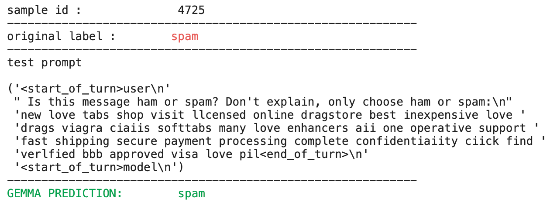

<br>

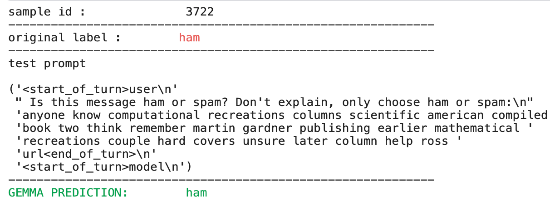


## My Another Projects
* [News Zero-Shot Topic Modelling w/BERTopic](https://www.kaggle.com/code/banddaniel/news-zero-shot-topic-modelling-w-bertopic)
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)
* [Gemma 2B Text Summarization w/Zero-Shot Prompting](https://www.kaggle.com/code/banddaniel/gemma-2b-text-summarization-w-zero-shot-prompting)



## References
1. https://ai.google.dev/gemma/docs/lora_tuning

In [ ]:
from IPython.display import clear_output
!pip install -q tensorflow-cpu
!pip install -q -U keras-nlp tensorflow-hub
!pip install -q -U keras>=3
!pip install -U tensorflow-text
!pip install nltk colorama
clear_output()

In [ ]:
import jax
devices = jax.devices("tpu")

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
from colorama import Fore, Back, Style
import pprint
from sklearn.model_selection import train_test_split

import keras
import keras_nlp


SEED = 2

# <span style="color:#e74c3c;"> Reading </span> Data

In [ ]:
# reading, dropping and shuffling
data = pd.read_csv('/kaggle/input/telegram-spam-or-ham/dataset.csv')
data.drop_duplicates(subset = ['text'], inplace = True)
data = data.sample(frac = 1, random_state = SEED).reset_index(drop = True)
data.head()

In [ ]:
# calculating max token numbers and dropping several samples
data['max']= data['text'].apply(lambda X: len(X.split()))
drop_idx = data[(data['max'] == 0) | (data['max'] == 1) | (data['max'] == 2)].index
data.drop(index = drop_idx, inplace = True)
data.reset_index(drop = True)
data.shape

# <span style="color:#e74c3c;"> Preprocessing </span>

In [ ]:
# preprocessing functions
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions 
full_data = data.copy()
full_data['preprocessed_text'] = data['text'].apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)

# <span style="color:#e74c3c;"> Dataset </span> Splitting

In [ ]:
train_data, test_data = train_test_split(full_data, test_size = 0.9, random_state = SEED, stratify = full_data['text_type'])

train_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

print('train samples :\t', train_data.shape[0])
print('test samples :\t', test_data.shape[0])

In [ ]:
train_data['text_type'].value_counts()

# <span style="color:#e74c3c;"> Creating </span> Prompts

In [ ]:
def create_instruct_dataset(df: pd.DataFrame, for_train : bool) -> np.array :
    dataset = []
    for index, row in df.iterrows():
        message, message_type = row['preprocessed_text'], row['text_type']
        if for_train:
            template = (f"<start_of_turn>user\n Is this message ham or spam? Don't explain, only choose ham or spam:\n{message}<end_of_turn>\n<start_of_turn>model\n{message_type}'<end_of_turn>")
        else:
            template = (f"<start_of_turn>user\n Is this message ham or spam? Don't explain, only choose ham or spam:\n{message}<end_of_turn>\n<start_of_turn>model\n")
        dataset.append(template)
        
    return dataset

In [ ]:
%%time
train_dataset = create_instruct_dataset(train_data, True)
test_dataset = create_instruct_dataset(test_data, False)

In [ ]:
# a train prompt example
pprint.pprint(train_dataset[40])

In [ ]:
# a test prompt example
pprint.pprint(test_dataset[660])

# <span style="color:#e74c3c;"> Gemma 2B</span> Model

In [ ]:
device_mesh = keras.distribution.DeviceMesh(
    (1, 8),
    ["batch", "model"],
    devices=keras.distribution.list_devices())


model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = (None, model_dim)
# Regex to match against the query, key and value matrices in the decoder
# attention layers
layout_map["decoder_block.*attention.*(query|key|value).*kernel"] = (None, model_dim, None)

layout_map["decoder_block.*attention_output.*kernel"] = (None, None, model_dim)
layout_map["decoder_block.*ffw_gating.*kernel"] = (model_dim, None)
layout_map["decoder_block.*ffw_linear.*kernel"] = (None, model_dim)

In [ ]:
model_parallel = keras.distribution.ModelParallel(device_mesh, layout_map, batch_dim_name="batch")
keras.distribution.set_distribution(model_parallel)
gemma = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_7b_en")

In [ ]:
# enabled lora
gemma.backbone.enable_lora(rank=8)

gemma.preprocessor.sequence_length = 256

optimizer = keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=0.01, beta_1=0.9, beta_2=0.999)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=optimizer, weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()])

my_callbacks = [keras.callbacks.EarlyStopping(monitor = 'loss',patience = 2, min_delta = 0.001)]

gemma.summary()

In [ ]:
# fine-tuning
gemma.fit(train_dataset, epochs = 30, batch_size = 1, callbacks = my_callbacks)

# <span style="color:#e74c3c;"> Test</span> Predictions

In [ ]:
# a function for creating test pipeline
# random test id -> generate with gemma -> split prediction

def predict_test_sample(original_df : pd.DataFrame, generated_prompt_arr : np.array, SEED: int = None):
    
    idx = np.random.default_rng(seed=SEED).permutation(original_df.shape[0])[0]
    print("sample id : \t\t", idx)
    print("--"*30)
    print("original label :\t" +Fore.RED + original_df.iloc[idx].text_type + Style.RESET_ALL)
    
    print("--"*30)
    print("test prompt \n")

    pprint.pprint(generated_prompt_arr[idx])
    print("--"*30)
    
    # gemma generated
    pred = gemma.generate(generated_prompt_arr[idx])

    if len(re.split("<start_of_turn>model\nham", pred)) == 2:
        print(Fore.GREEN + 'GEMMA PREDICTION: \t ham' + Style.RESET_ALL)

    elif len(re.split("<start_of_turn>model\nspam", pred)) ==2:
        print(Fore.GREEN + 'GEMMA PREDICTION: \t spam' + Style.RESET_ALL)
    else:
        print(Fore.RED + 'There is no answer. Probably, the test sample is bad.' + Style.RESET_ALL)


In [ ]:
predict_test_sample(test_data, test_dataset, 2870)

In [ ]:
predict_test_sample(test_data, test_dataset, 43)

In [ ]:
predict_test_sample(test_data, test_dataset, 923)

In [ ]:
predict_test_sample(test_data, test_dataset, 544)

In [ ]:
predict_test_sample(test_data, test_dataset, 6529)